# Introduction

In this notebook, I will analyse the Seattle AirBNB Dataset from Inside AirBnb. I will follow the CRISP-DM process when analysing their data. The CRISP-DM stages are:

1. Business Understanding
1. Data Understanding
1. Data Preparation
1. Modelling
1. Evaluation
1. Deployment

# Business Understanding
    
In this project, a mail-order sales company in Germany is interested in identifying **segments of the general population to target** with their marketing in order to grow. The objective is to identify which individuals are most likely to respond to the campaign and become customers of the mail-order company.

In this section, I will first focus on identifying the parts on the population that **best describe the core customer base** of the company **using customer segmentation**.

# Data Understanding

In this step, I will focus on understanding the Arvato and Germany Demographics data. I will do this as follows:
1. Create Pandas Profiling reports and analyse them i.e. [Geramany Pop Demographics Report](../data/raw/population_demographics.html) and [Customer Demographics Report](../data/raw/customer_demographics.html)
1. Note down **observations** and **action points** from Analysis

## Load Datasets

In [1]:
import pandas as pd
import numpy as np
import pandas_profiling as pp
import matplotlib.pyplot as plt

pd.set_option("display.max_columns",50)
%matplotlib inline

home_dir = '../'
data_dir = home_dir + 'data/'
raw_dir = data_dir + 'raw/'
processed_dir = data_dir + 'processed/'

In [2]:
%%time
train_demographics = pd.read_csv(raw_dir + 'Udacity_MAILOUT_052018_TRAIN.csv', sep=';', low_memory=False)

Wall time: 1.53 s


## Generate Pandas Profiling Reports

In [4]:
kwargs = dict(correlations={
        "pearson": {"calculate": False, 'warn_high_correlations': True},
        "spearman": {"calculate": False, 'warn_high_correlations': True},
        "kendall": {"calculate": False, 'warn_high_correlations': False},
        "phi_k": {"calculate": False, 'warn_high_correlations': False},
        "cramers": {"calculate": False, 'warn_high_correlations': False},
    }, missing_diagrams=None, interactions=None)

In [6]:
%%time
pp.ProfileReport(train_demographics, title='Train Demographics', **kwargs).to_file(raw_dir + 'train_demographics.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Wall time: 1min 38s


## Observations

1. The Demographics data uses **PLZ8 data**. You can find more info in it [here](https://www.regionale-marktdaten.de/plz8/) or [here](https://ddsgeo.com/download/flyer/PLZ8_eng_Flyer.pdf).
1. It also uses **grid data**. You can find more info on this dataset [here](https://www.regionale-marktdaten.de/az-deutschland-raster/).
1. It also has records of Information Level RR1_ID, RR3_ID and RR4_ID which are all different **spatial levels**. RR3_ID and RR4_ID are all associated with the **microcell level**, however I could not find a concise explanation for this spatial level beyond a small geographic area covered by a cellular carrier or some other transmission system.
1. Many features have a large proportion of unknown values i.e. -1 or 0
1. The features are too many to manually asses and drop.

## Action Points
1. Feed datasets with minimal data cleanin and transformation to algorithms to discover important features.

# Data Preparation

In this section, I clean and transform the Demographics data in preparation for clustering with HDBSCAN

In [3]:
from sklearn.preprocessing import MinMaxScaler, FunctionTransformer, Normalizer, LabelEncoder

In [4]:
# Identifying columns that have more than 90% nulls
train_missing = train_demographics.isna().sum()/train_demographics.shape[0]
missing_data_cols = train_missing.reset_index().sort_values(by=0, ascending=False).rename(columns={0:'Missing_Proportion'}).query("Missing_Proportion > 0.9")['index'].tolist()
missing_data_cols

['ALTER_KIND4', 'ALTER_KIND3', 'ALTER_KIND2', 'ALTER_KIND1']

In [184]:
def clean_transform_demographics_data(demographics_df, missing_data_cols_, customer_data=True, drop_dups=True):
    """
    This method cleans and transforms the demographics data. It takes the following steps:
        1. Drop unneeded columns
        2. Peform Label Encoding on columns that represent Year and on String/Object columns
        3. Perform feature scaling on specific features
        4. Fill all nulls with -1. (This represents Unknown for most features)
        5. Drop Duplicates
        
    :param demographics_df: 
    :param missing_data_cols: Columns that have a large proportion of missing data
    :param customer_data: Boolean variable that indicates if demographics_df is customer data or population data
    :param drop_dups: Boolean variable that indicates if duplicates should be dropped
    :return: Transformed demographics_df, Label Encoding Dict, Scaling Dict
    """
    demographics_df = demographics_df.copy()
    
    if customer_data:
        drop_columns = ['PRODUCT_GROUP','CUSTOMER_GROUP', 'ONLINE_PURCHASE']
    else:
        drop_columns = []
    
    # Columns missing more than 90% of their data
    drop_columns += missing_data_cols_

    # EINGEFUEGT_AM -> Inserted On (Date the record was inserted into the dataset)
    # LNR -> Record ID (Not necessary)
    # ANZ_HH_TITEL -> number of holders of an academic title in the building (Mostly 0)
    drop_columns += ['LNR', 'EINGEFUEGT_AM', 'ANZ_HH_TITEL']
    
    demographics_df = demographics_df.drop(columns=drop_columns)

    # Label Encoding
    object_ = object
    obj_cols = demographics_df.dtypes.reset_index().rename(columns={0:'Temp'}).query("Temp == @object_")['index'].tolist()
    year_cols = 'EINGEZOGENAM_HH_JAHR,GEBURTSJAHR,MIN_GEBAEUDEJAHR'.split(',')
    labeller_dict = dict()
    for col in obj_cols + year_cols:
        series_ = demographics_df[col]
        labeller_dict[col] = LabelEncoder().fit(series_)
        demographics_df[col] = labeller_dict[col].transform(series_)

    # Feature Scaling
    scaler_dict = dict()
    # KBA13_ANZAHL_PKW -> number of cars in the PLZ8
    # ANZ_HAUSHALTE_AKTIV -> number of households known in this building
    # ANZ_STATISTISCHE_HAUSHALTE -> Similar to ANZ_HAUSHALTE_AKTIV in values
    scale_cols = "KBA13_ANZAHL_PKW,ANZ_HAUSHALTE_AKTIV,ANZ_STATISTISCHE_HAUSHALTE".split(',')
    for col in scale_cols:
        series_ = demographics_df[[col]]
        scaler_dict[col] = MinMaxScaler(feature_range=(0,10)).fit(series_)
        demographics_df[col] = scaler_dict[col].transform(series_)

    demographics_df = demographics_df.fillna(-1)
    
    if drop_dups:
        demographics_df = demographics_df.drop_duplicates()
    
    return demographics_df, labeller_dict, scaler_dict

In [6]:
%%time
train_demographics_clean, _, _ = clean_transform_demographics_data(train_demographics, missing_data_cols, customer_data=False)
del train_demographics

Wall time: 825 ms


# Modelling

In this section, I perform:
1. Clustering using UMAP and HDBSCAN models
1. Prediction of Customers using Grid Search

## Clustering using UMAP and HDBSCAN models

In [9]:
import hdbscan
import _pickle as cPickle

from sklearn.manifold import TSNE
import umap

In [11]:
clustering_algo_columns = pd.read_csv(processed_dir + "demographics_clean_sample_final.csv").drop(columns=['Customer', 'clusters', 'clusters_prob']).columns.tolist()

In [80]:
def clustering_with_umap_hdbscan(demographics_clean, clustering_algo_columns):
    """
    This method performs clustering on the demographics_clean dataset. It does this by first performing dimensionality reduction.
    
    :param demographics_clean: 
    :param clustering_algo_columns: The columns that should be feed to the UMAP algorithm
    :return: New matrix generated from the dimensionality reduction and the list of cluster labels
    """ 
    with open(processed_dir + 'umap_dimension_reduction_all.pkl', mode='rb+') as fp:
        umap_fitted = cPickle.load(fp)

    with open(processed_dir + 'hbdscan_umap_clusterer_all.pkl', mode='rb+') as fp:
        hbdscan_fitted = cPickle.load(fp)
    
    cluster_embeddings = umap_fitted.transform(demographics_clean[clustering_algo_columns].values)
    del umap_fitted

    clusters = hdbscan.approximate_predict(hbdscan_fitted, cluster_embeddings)
    del hbdscan_fitted
    
    return cluster_embeddings, clusters

In [12]:
%%time
train_cluster_embeddings, train_clusters = clustering_with_umap_hdbscan(train_demographics_clean)

Wall time: 7min 40s


In [14]:
def analyse_clusters(pred_cluster):
    """
    This method performs a simple and quick analysis of the predicted clusters
    
    :param pred_cluster: Cluster labels
    :return: None
    """
    fig, axes = plt.subplots(1,2, figsize = (14,5))
    titles = ['s', ' Probabilites']
    for train_vals, ax, ttl in zip(pred_cluster, axes, titles):
        ax.hist(train_vals)
        ax.set_title(f"Histogram of Cluster{ttl}")

    print('Cluster Value Count\n', pd.Series(pred_cluster[0]).value_counts())

    plt.show()

Cluster Value Count
  10    18567
 13     3694
-1      2627
 14     2578
 32     1233
       ...  
 34        1
 22        1
 97        1
 78        1
 92        1
Length: 106, dtype: int64


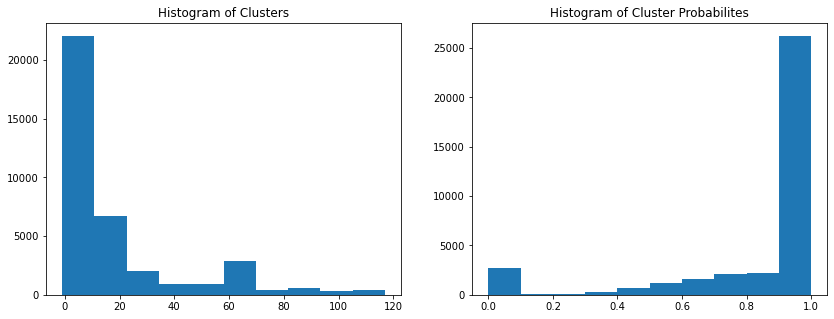

In [15]:
analyse_clusters(train_clusters)

In [59]:
test_dataset_s__.value_counts(normalize=True)

0    0.987285
1    0.012715
Name: RESPONSE, dtype: float64

## Training using Grid Search

In [270]:
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import multilabel_confusion_matrix, confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_auc_score
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, KMeansSMOTE
from imblearn.pipeline import Pipeline as imbpipeline
import lightgbm as lgb

import shap

In [101]:
def create_input_dataset(demographics_clean=train_demographics_clean, cluster_embeddings=train_cluster_embeddings, clusters=train_clusters, selected_columns=clustering_algo_columns, embeddings_bool=True, test_dataset=False, **kwargs):
    """
    This method creates the input dataset to the ML Pipeline.It takes the following steps:
        1. Create input_dataset array.
        2. Convert input_dataset array to DataFrame
        3. Extract Customer_Likely Feature. This is based on the clusters where we're likely to have more customers. It's the output of the first step of the project
        4. Fetch the list of all columns as well as the list of categorical features
    
    :param demographics_clean:
    :param cluster_embeddings: Embeddings generated by the UMAP algorithm
    :param selected_columns: 
    :param embeddings_bool: Boolean value indicating if training should be performed on the Embeddings produced by the UMAP algorithm
    :param test_dataset: Boolean that prevents the creation of target_dataset_s if we're creating the test dataset
    :return:
    """
    if embeddings_bool:
        input_dataset = np.concatenate([cluster_embeddings, clusters[0].reshape(-1,1), clusters[1].reshape(-1,1)], axis=1)
        input_dataset_df = pd.DataFrame(input_dataset, columns=list(map(str, np.arange(0,10))) + ['clusters', 'clusters_prob'])
        input_dataset_df['customer_likely'] = input_dataset_df.clusters.isin([4,31,13,14,48,26,49,10,36,25,37,21,44,29,17,41,16,114,112]).astype(int)
        
        all_columns = input_dataset_df.columns.tolist()
        categ_features = ['clusters', 'customer_likely']
    else:
        input_dataset = np.concatenate([demographics_clean[selected_columns], clusters[0].reshape(-1,1), clusters[1].reshape(-1,1)], axis=1)
        input_dataset_df = pd.DataFrame(input_dataset, columns=selected_columns + ['clusters', 'clusters_prob'])
        input_dataset_df['customer_likely'] = input_dataset_df.clusters.isin([4,31,13,14,48,26,49,10,36,25,37,21,44,29,17,41,16,114,112]).astype(int)
                
        all_columns = input_dataset_df.columns.tolist()
        non_categ_features = 'ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,KBA13_ANZAHL_PKW,clusters_prob'.split(',')
        categ_features = [col for col in all_columns if col not in non_categ_features]
    
    if test_dataset:
        target_dataset_s = None
    else:
        target_dataset_s = demographics_clean['RESPONSE']
    
    return input_dataset_df, target_dataset_s, all_columns, categ_features

In [171]:
%%time
def build_model(smote_type='normal', **kwargs):
    """
    This method builds a ML Model using Grid Search. It takes the following steps:
        1. Create the input dataset
        2. Perform Test Train Split
        3. Create an imbalancelearn pre-processing Pipeline
        4. Perform Grid Search using Stratified KFold
    
    :param smote_type: The Type of SMOTE Algorithm to use 
    :return: Grid Search object
    """
    random_seed = 42
    
    train_dataset_df_, test_dataset_s_, all_columns, categ_features = create_input_dataset(**kwargs)
    
    X_train, X_test, y_train, y_test = train_test_split(train_dataset_df_, test_dataset_s_, test_size=0.2, random_state=random_seed)
    
    param_grid = {'clf__learning_rate':[0.1, 0.01, 0.001], 'clf__n_estimators': [100, 500, 1000, 2000], 'clf__class_weight': [None, 'balanced'], 'smote__k_neighbors': [10, 20, 30, 50, 100]}
    
    if smote_type == 'borderline':
        param_grid['smote__kind'] = ['borderline-1', 'borderline-2']
        
        pipeline = imbpipeline(steps = [['smote', BorderlineSMOTE(random_state=random_seed)],
                                        ['clf', lgb.LGBMClassifier(random_state=random_seed, n_jobs=-1, objective='binary')]])

    elif smote_type == 'normal':
        pipeline = imbpipeline(steps = [['smote', SMOTE(random_state=random_seed)],
                                        ['clf', lgb.LGBMClassifier(random_state=random_seed, n_jobs=-1, objective='binary')]])
        
    elif smote_type == 'kmeans':
        param_grid['smote__kmeans_estimator'] = [10, 100, 150]
        param_grid['smote__cluster_balance_threshold'] = [0.005, 0.01, 0.05]
        
        pipeline = imbpipeline(steps = [['smote', KMeansSMOTE(random_state=random_seed)],
                                        ['clf', lgb.LGBMClassifier(random_state=random_seed, n_jobs=-1, objective='binary')]])
    
    stratified_kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=11)

    grid_search = GridSearchCV(estimator=pipeline,
                               param_grid=param_grid,
                               scoring='roc_auc',
                               cv=stratified_kfold,
                               n_jobs=-1)

    grid_search.fit(X_train, y_train, clf__feature_name=all_columns, clf__categorical_feature=categ_features, clf__eval_metric='binary_logloss')

    cv_score = grid_search.best_score_
    test_score = grid_search.score(X_test, y_test)
    best_params = grid_search.best_params_
    print(f'Best Params: {best_params}\nCross-validation score: {cv_score}\nTest score: {test_score}')
    
    return grid_search

Wall time: 0 ns


In [18]:
grid_search_output_dict = dict()

In [19]:
%%time
print("Training using UMAP Embeddings")
smote_type='normal'
grid_search_output_dict[True, smote_type] = build_model(embeddings_bool=True, smote_type=smote_type)

Training using UMAP Embeddings


E:\ProgramData\Miniconda3\envs\project_4_udacity\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


Best Params: {'clf__class_weight': None, 'clf__learning_rate': 0.1, 'clf__n_estimators': 2000, 'smote__k_neighbors': 20}
Cross-validation score: 0.5491080374272207
Test score: 0.5240687809083073
Wall time: 6min 17s


In [20]:
%%time
print("Training using Raw Features")
smote_type='normal'
grid_search_output_dict[False, smote_type] = build_model(embeddings_bool=False, smote_type=smote_type)

Training using Raw Features


E:\ProgramData\Miniconda3\envs\project_4_udacity\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


Best Params: {'clf__class_weight': None, 'clf__learning_rate': 0.01, 'clf__n_estimators': 500, 'smote__k_neighbors': 100}
Cross-validation score: 0.7486537151975914
Test score: 0.7482960640799916
Wall time: 1h 1min 6s


In [21]:
%%time
print("Training using UMAP Embeddings -> SMOTE Borderline")
smote_type='borderline'
grid_search_output_dict[True, smote_type] = build_model(embeddings_bool=True, smote_type=smote_type)

Training using UMAP Embeddings -> SMOTE Borderline


E:\ProgramData\Miniconda3\envs\project_4_udacity\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


Best Params: {'clf__class_weight': None, 'clf__learning_rate': 0.1, 'clf__n_estimators': 1000, 'smote__k_neighbors': 20, 'smote__kind': 'borderline-2'}
Cross-validation score: 0.5609567430847728
Test score: 0.48937610406412685
Wall time: 12min 33s


In [22]:
%%time
print("Training using Raw Features -> SMOTE Borderline")
smote_type='borderline'
grid_search_output_dict[False, smote_type] = build_model(embeddings_bool=False, smote_type=smote_type)

Training using Raw Features -> SMOTE Borderline


E:\ProgramData\Miniconda3\envs\project_4_udacity\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


Best Params: {'clf__class_weight': None, 'clf__learning_rate': 0.01, 'clf__n_estimators': 100, 'smote__k_neighbors': 30, 'smote__kind': 'borderline-2'}
Cross-validation score: 0.7526483299698157
Test score: 0.7638104061199729
Wall time: 1h 55min 7s


In [71]:
%%time
print("Training using UMAP Embeddings -> SMOTE KMeans")
smote_type='kmeans'
grid_search_output_dict[True, smote_type] = build_model(embeddings_bool=True, smote_type=smote_type)

Training using UMAP Embeddings -> SMOTE KMeans


C:\Users\ktmbugua\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_search.py:921: UserWarning: One or more of the test scores are non-finite: [0.53483529 0.53346806        nan ...        nan        nan        nan]
  category=UserWarning
E:\ProgramData\Miniconda3\envs\project_4_udacity\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


Best Params: {'clf__class_weight': None, 'clf__learning_rate': 0.1, 'clf__n_estimators': 500, 'smote__cluster_balance_threshold': 0.005, 'smote__k_neighbors': 10, 'smote__kmeans_estimator': 10}
Cross-validation score: 0.5490736063747034
Test score: 0.5104153403261664
Wall time: 16min 33s


In [72]:
%%time
print("Training using Raw Features -> SMOTE KMeans")
smote_type='kmeans'
grid_search_output_dict[False, smote_type] = build_model(embeddings_bool=False, smote_type=smote_type)

Training using Raw Features -> SMOTE KMeans


C:\Users\ktmbugua\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_search.py:921: UserWarning: One or more of the test scores are non-finite: [0.7323474       nan       nan ...       nan       nan       nan]
  category=UserWarning
E:\ProgramData\Miniconda3\envs\project_4_udacity\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


Best Params: {'clf__class_weight': 'balanced', 'clf__learning_rate': 0.01, 'clf__n_estimators': 500, 'smote__cluster_balance_threshold': 0.005, 'smote__k_neighbors': 10, 'smote__kmeans_estimator': 10}
Cross-validation score: 0.7627481691318012
Test score: 0.744064946412185
Wall time: 1h 42min 48s


In [73]:
with open(processed_dir + 'grid_search_results_dict.pkl', mode='wb') as fp:
    cPickle.dump(grid_search_output_dict, fp)

# Evaluation

Here, we evaluate the model using SHAP and train a final version

In [106]:
train_dataset_df_, test_dataset_s_, all_columns, categ_features = create_input_dataset(embeddings_bool=False)
X_train, X_test, y_train, y_test = train_test_split(train_dataset_df_, test_dataset_s_, test_size=0.2, random_state=42)
# X_train, y_train = SMOTE(k_neighbors=100, random_state=42).fit_resample(X_train, y_train)

In [108]:
%%time
# Explain Model using Shap
explainer = shap.TreeExplainer(grid_search_output_dict[False, 'normal'].best_estimator_['clf'])
shap_values = explainer.shap_values(X_train)

Wall time: 29.7 s


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


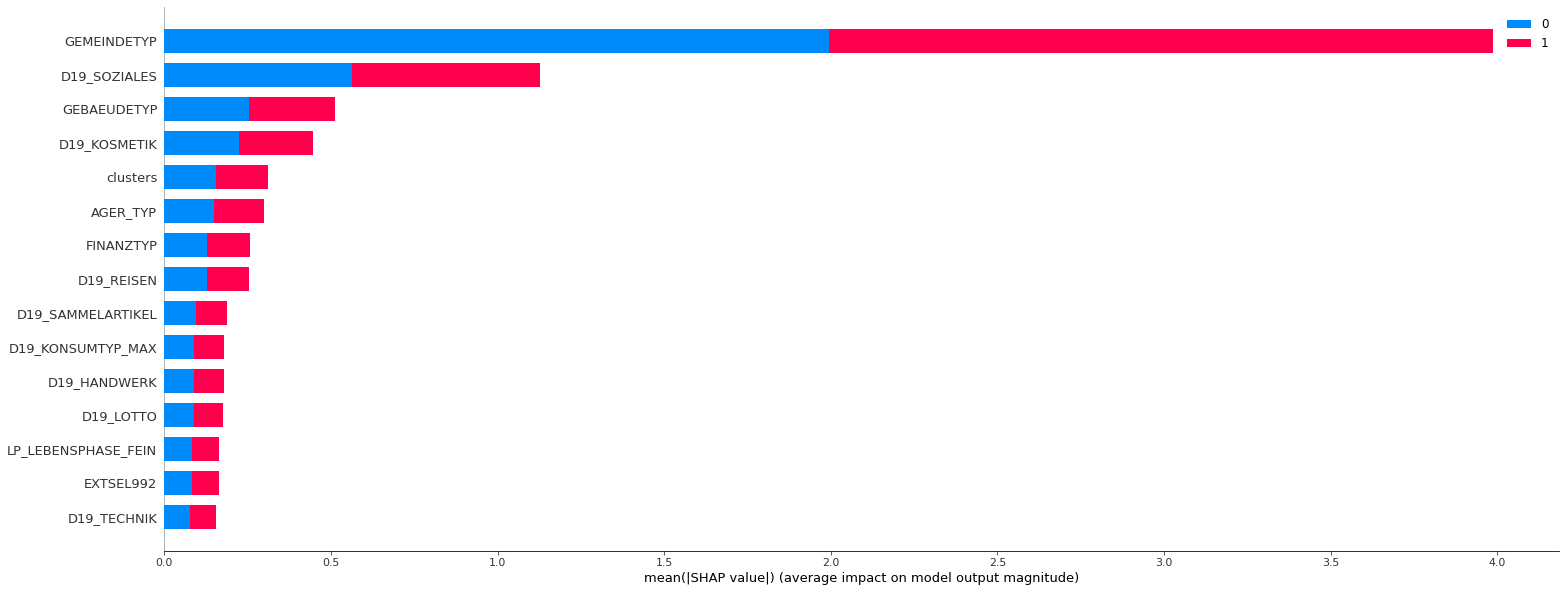

In [112]:
# Plot Summary Plot
shap.summary_plot(shap_values, X_train, class_names=np.arange(0,2), plot_type='bar', max_display=15, plot_size=(25, 10), feature_names=all_columns)

In [116]:
# Plot Summary Plot
def plot_cluster_summary_plot(cluster_no, no_of_features=5, plot_type='bar', shap_values=shap_values, X_train=X_train, all_columns=all_columns):
    """
    This method plots a summary plot for a single cluster
    
    :param cluster_no:
    :param no_of_features: No of features to plot
    :param plot_type:
    :param shap_values: Generated Shaply Values
    :param X_train:
    :param max_data_points:
    :param all_columns: List of column names that were in the training dataset
    :return: None
    """ 
    fig, axes = plt.subplots(1,1, figsize=(5, 5))

    shap.summary_plot(shap_values[cluster_no], X_train, plot_type=plot_type, show=False, max_display=no_of_features, plot_size=(10, 5), feature_names=all_columns)
    axes.set_title(f"Class {cluster_no} Summary Plot")
    plt.show()

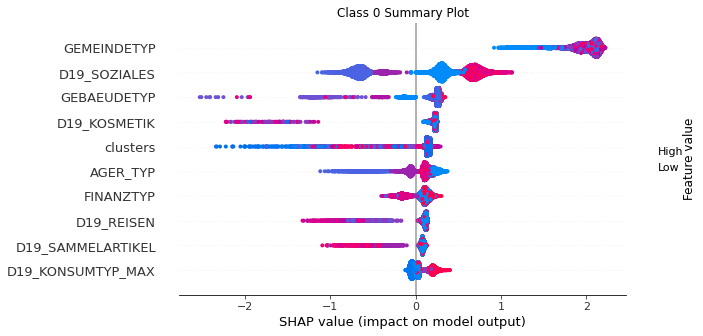

In [119]:
plot_cluster_summary_plot(0, no_of_features=10, plot_type='dot')

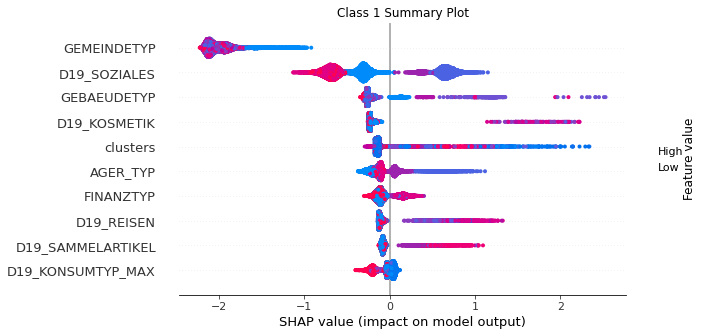

In [120]:
plot_cluster_summary_plot(1, no_of_features=10, plot_type='dot')

Comments:
- Top 2 features are not in the Data Dictionaries. However,
    - GEMEINDETYPE means Community Type
    - D19_SOZIALES means Social
- GEBAEUDETYPE (Building Type: Commercial/Residential). Mixed building has a 

In [178]:
# Shap Feature Importances
feature_importance_values = np.abs(shap_values[0]).mean(axis=0) + np.abs(shap_values[1]).mean(axis=0)
shap_feature_importances = np.array(all_columns)[np.argsort(feature_importance_values)[::-1]]

# Selecting features that have a greater than 0.5% impact on the output of the model relative to the Top Feature
selected_features = feature_importance_values/feature_importance_values.max()*100 > 0.5
top_selected_features = list(np.array(all_columns)[selected_features][:-2])  # Added [:-2] to remove the clusters features since they are added in the create_input_dataset function

Rerunning the Model Build Process after dropping unnecessary columns

In [180]:
feature_set = top_selected_features

In [181]:
%%time
print("Training using Raw Features -> Normal SMOTE")
smote_type='normal'
grid_search_final = build_model(embeddings_bool=False, smote_type=smote_type, selected_columns=feature_set)

Training using Raw Features -> Normal SMOTE


Using categorical_feature in Dataset.


Best Params: {'clf__class_weight': None, 'clf__learning_rate': 0.01, 'clf__n_estimators': 500, 'smote__k_neighbors': 50}
Cross-validation score: 0.7531799848194426
Test score: 0.7443444841065989
Wall time: 26min 7s


In [182]:
%%time
print("Training using Raw Features -> SMOTE Borderline")
smote_type='borderline'
grid_search_best = build_model(embeddings_bool=False, smote_type=smote_type, selected_columns=feature_set)

Training using Raw Features -> SMOTE Borderline


Using categorical_feature in Dataset.


Best Params: {'clf__class_weight': None, 'clf__learning_rate': 0.01, 'clf__n_estimators': 500, 'smote__k_neighbors': 50, 'smote__kind': 'borderline-1'}
Cross-validation score: 0.7549685535053167
Test score: 0.7544429662608246
Wall time: 33min 41s


In [417]:
def plot_roc_curve(y_test, y_pred_prob):
    """
    This method plots an ROC curve given the y_test and y_pred_prob
    
    :param y_test:
    :param y_pred_prob: Probability that a recepient of a campaign will become a customer
    :return: None
    """
    fpr_logis, tpr_logis, thresholds_logis = roc_curve(y_test, y_pred_prob)

    fig, ax = plt.subplots(figsize=(10, 7))
    # plotting the "guessing" model
    plt.plot([0, 1], [0, 1], 'k--')
    # plotting the logistic model
    plt.plot(fpr_logis, tpr_logis)
    plt.fill_between(fpr_logis, tpr_logis, alpha=0.2, color='b')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    auc_score = roc_auc_score(y_test, y_pred_prob)
    plt.title('ROC curve: AUC={0:0.3f}'.format(auc_score))
    plt.show()

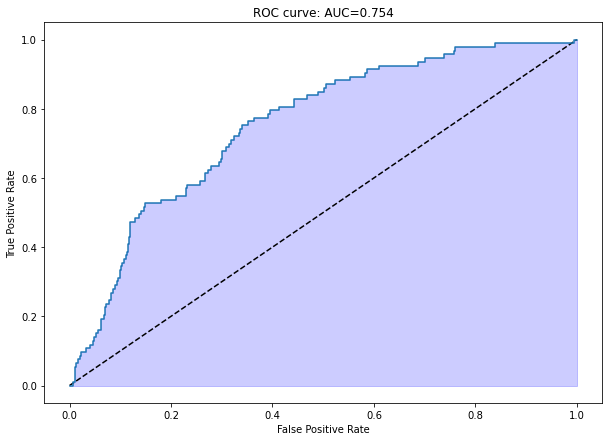

In [416]:
train_dataset_df_, test_dataset_s_, _, _ = create_input_dataset(embeddings_bool=False, selected_columns=feature_set)
_, X_test, _, y_test = train_test_split(train_dataset_df_, test_dataset_s_, test_size=0.2, random_state=random_seed)
y_pred_prob = grid_search_best.best_estimator_.predict_proba(X_test)[:,1]
    
plot_roc_curve(y_test, y_pred_prob)

In [242]:
with open(processed_dir + 'grid_search_best.pkl', mode='wb') as fp:
    cPickle.dump(grid_search_best, fp)
    
with open(processed_dir + 'grid_search_final.pkl', mode='wb') as fp:
    cPickle.dump(grid_search_final, fp)

# Deployment

In this final stage, I will perform the predictions on the Test Dataset

In [186]:
%%time
test_demographics = pd.read_csv(raw_dir + 'Udacity_MAILOUT_052018_TEST.csv', sep=';', low_memory=False)

test_demographics_clean, _, _ = clean_transform_demographics_data(test_demographics, missing_data_cols, customer_data=False, drop_dups=False)

test_cluster_embeddings, test_clusters = clustering_with_umap_hdbscan(test_demographics_clean, clustering_algo_columns=clustering_algo_columns)

Wall time: 10min 32s


In [403]:
random_seed = 42
test_dataset_df_, _, all_columns, categ_features = create_input_dataset(demographics_clean=test_demographics_clean, cluster_embeddings=test_cluster_embeddings, clusters=test_clusters, selected_columns=feature_set, embeddings_bool=False, test_dataset=True)

test_responses = grid_search_best.best_estimator_.predict_proba(test_dataset_df_)[:, 1]

test_demographics_clean['PREDICTED_RESPONSE'] = test_responses

In [414]:
test_demographics_clean.to_csv(processed_dir + "Udacity_MAILOUT_Predictions.csv", index=False)

In [306]:
y_train.value_counts(), y_train.value_counts(normalize=True)

(0    29380
 1      380
 Name: RESPONSE, dtype: int64,
 0    0.987231
 1    0.012769
 Name: RESPONSE, dtype: float64)